# Uso de una red neuronal tipo SLTM para las predicciones de venta

In [1]:
import cx_Oracle as oc
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


### se obtiene la venta por semana de un solo modelo

In [120]:
con=oc.connect('SYSTEM/admin@localhost')

sql=pd.read_sql_query('''
SELECT
    v.ult_sust_def_n art,v.talla_ini_min,v.talla_fin_max,TRUNC(fecha, 'iw') + 7 - 1/86400 AS fecha, -- semana
    SUM(venta) vta
FROM
    ventas   v
WHERE
    v.ult_sust_def_n = 96723 --modelo de prueba
GROUP BY
    v.ult_sust_def_n,v.talla_ini_min,v.talla_fin_max,TRUNC(fecha, 'iw') + 7 - 1/86400 -- agrupa la venta por semana
ORDER BY fecha -- se ordena por fecha para hacer el analisis correctamente
''',con)

df=pd.DataFrame(sql)
df = df.set_index('FECHA')
df.shape

(27, 4)

### Gráfica del histórico de las ventas del modelo por semana

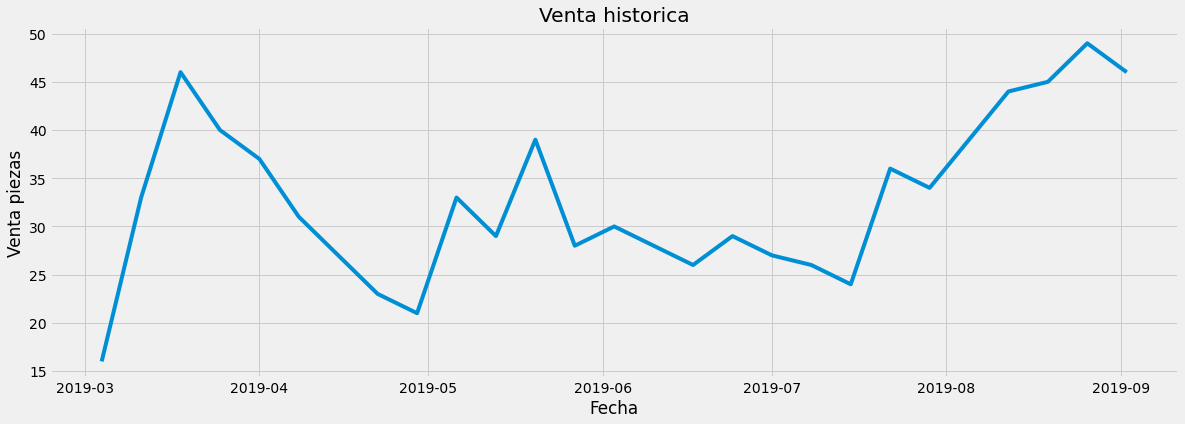

In [25]:
plt.figure(figsize=(18,6))
plt.title('Venta historica')
plt.plot(df['VTA'])
plt.xlabel('Fecha')
plt.ylabel('Venta piezas')
plt.show()

### se toma el 80% de los datos para hacer el entrenamiento

In [89]:
data=df.filter(['VTA'])
dataset=data.values
training_data_len=math.ceil(len(dataset)*0.8)
training_data_len

22

### se escalan los valores de la venta para que no afecten valores altos o bajos

In [90]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
#scaled_data

### se toman los datos hasta antes de 4 semanas

In [91]:
semanas=4
train_data=scaled_data[0:training_data_len,:]
x_train=[]
y_train=[]
for i in range(semanas,len(train_data)):
    x_train.append(train_data[i-semanas:i,0])
    y_train.append(train_data[i,0])
    if i<=semanas:
        print(x_train)
        print(y_train)
        print()

[array([0.        , 0.51515152, 0.90909091, 0.72727273])]
[0.6363636363636365]



In [92]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [93]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(18, 4, 1)

### se crea la estructura de la red neuronal

In [111]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [112]:
model.compile(optimizer='adam',loss='mean_squared_error')

### se hace el entrenamiento

In [113]:
model.fit(x_train,y_train,batch_size=1,epochs=1)

Epoch 1/1
18/18 [==============================] - 1s 79ms/step - loss: 0.0762


In [114]:
test_data=scaled_data[training_data_len-semanas:,:]
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(semanas,len(test_data)):
    x_test.append(test_data[i-semanas:i,0])
    

In [115]:
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

### se hacen las predicciones

In [116]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

### se calcula el error

In [117]:
rmse=np.sqrt(np.mean(predictions - y_test)**2)
rmse

10.308026885986328

### Gráfica de la historia de venta, las predicciones y la venta real

C:\Users\jcjim\.conda\envs\NN\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


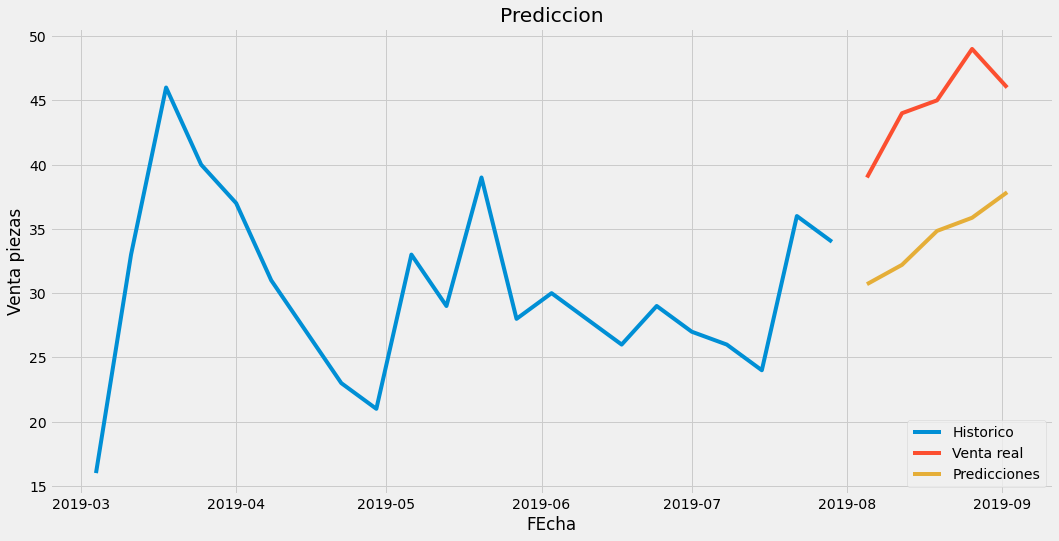

In [118]:
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions']=predictions

plt.figure(figsize=(16,8))
plt.title('Prediccion')
plt.xlabel('FEcha')
plt.ylabel('Venta piezas')
plt.plot(train['VTA'])
plt.plot(valid[['VTA','Predictions']])
plt.legend(['Historico','Venta real','Predicciones'],loc='lower right')
plt.show()

### se confrontan las predicciones vs venta real

In [119]:
valid

,VTA,Predictions
FECHA,,
2019-08-04 23:59:59,39,30.699001
2019-08-11 23:59:59,44,32.202656
2019-08-18 23:59:59,45,34.842651
2019-08-25 23:59:59,49,35.866177
2019-09-01 23:59:59,46,37.849380
